## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import missingno as msno


from pprint import pprint


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix


from lightgbm import LGBMClassifier


from keras.layers import Dense,Activation
from keras.models import Sequential

pd.set_option('display.max_columns', None)

## Parameters

In [2]:
currentFolder = os.getcwd()

dataFolder = os.path.join(currentFolder, 'data')

## Functions

## Read Files

In [3]:
fileReaded = pd.read_csv(
    os.path.join(dataFolder, 'diabetic_data.csv'), sep = ','
).replace(
    '?', np.nan
).replace(
    'Unknown/Invalid', np.nan
).replace(
    'None', np.nan
)

fileReaded.columns = [i.upper().strip() for i in fileReaded.columns]

### Analyze Missing Values

### Data Types

In [4]:
fileReaded.dtypes

ENCOUNTER_ID                 int64
PATIENT_NBR                  int64
RACE                        object
GENDER                      object
AGE                         object
WEIGHT                      object
ADMISSION_TYPE_ID            int64
DISCHARGE_DISPOSITION_ID     int64
ADMISSION_SOURCE_ID          int64
TIME_IN_HOSPITAL             int64
PAYER_CODE                  object
MEDICAL_SPECIALTY           object
NUM_LAB_PROCEDURES           int64
NUM_PROCEDURES               int64
NUM_MEDICATIONS              int64
NUMBER_OUTPATIENT            int64
NUMBER_EMERGENCY             int64
NUMBER_INPATIENT             int64
DIAG_1                      object
DIAG_2                      object
DIAG_3                      object
NUMBER_DIAGNOSES             int64
MAX_GLU_SERUM               object
A1CRESULT                   object
METFORMIN                   object
REPAGLINIDE                 object
NATEGLINIDE                 object
CHLORPROPAMIDE              object
GLIMEPIRIDE         

#### Missing Values Plot

<AxesSubplot: >

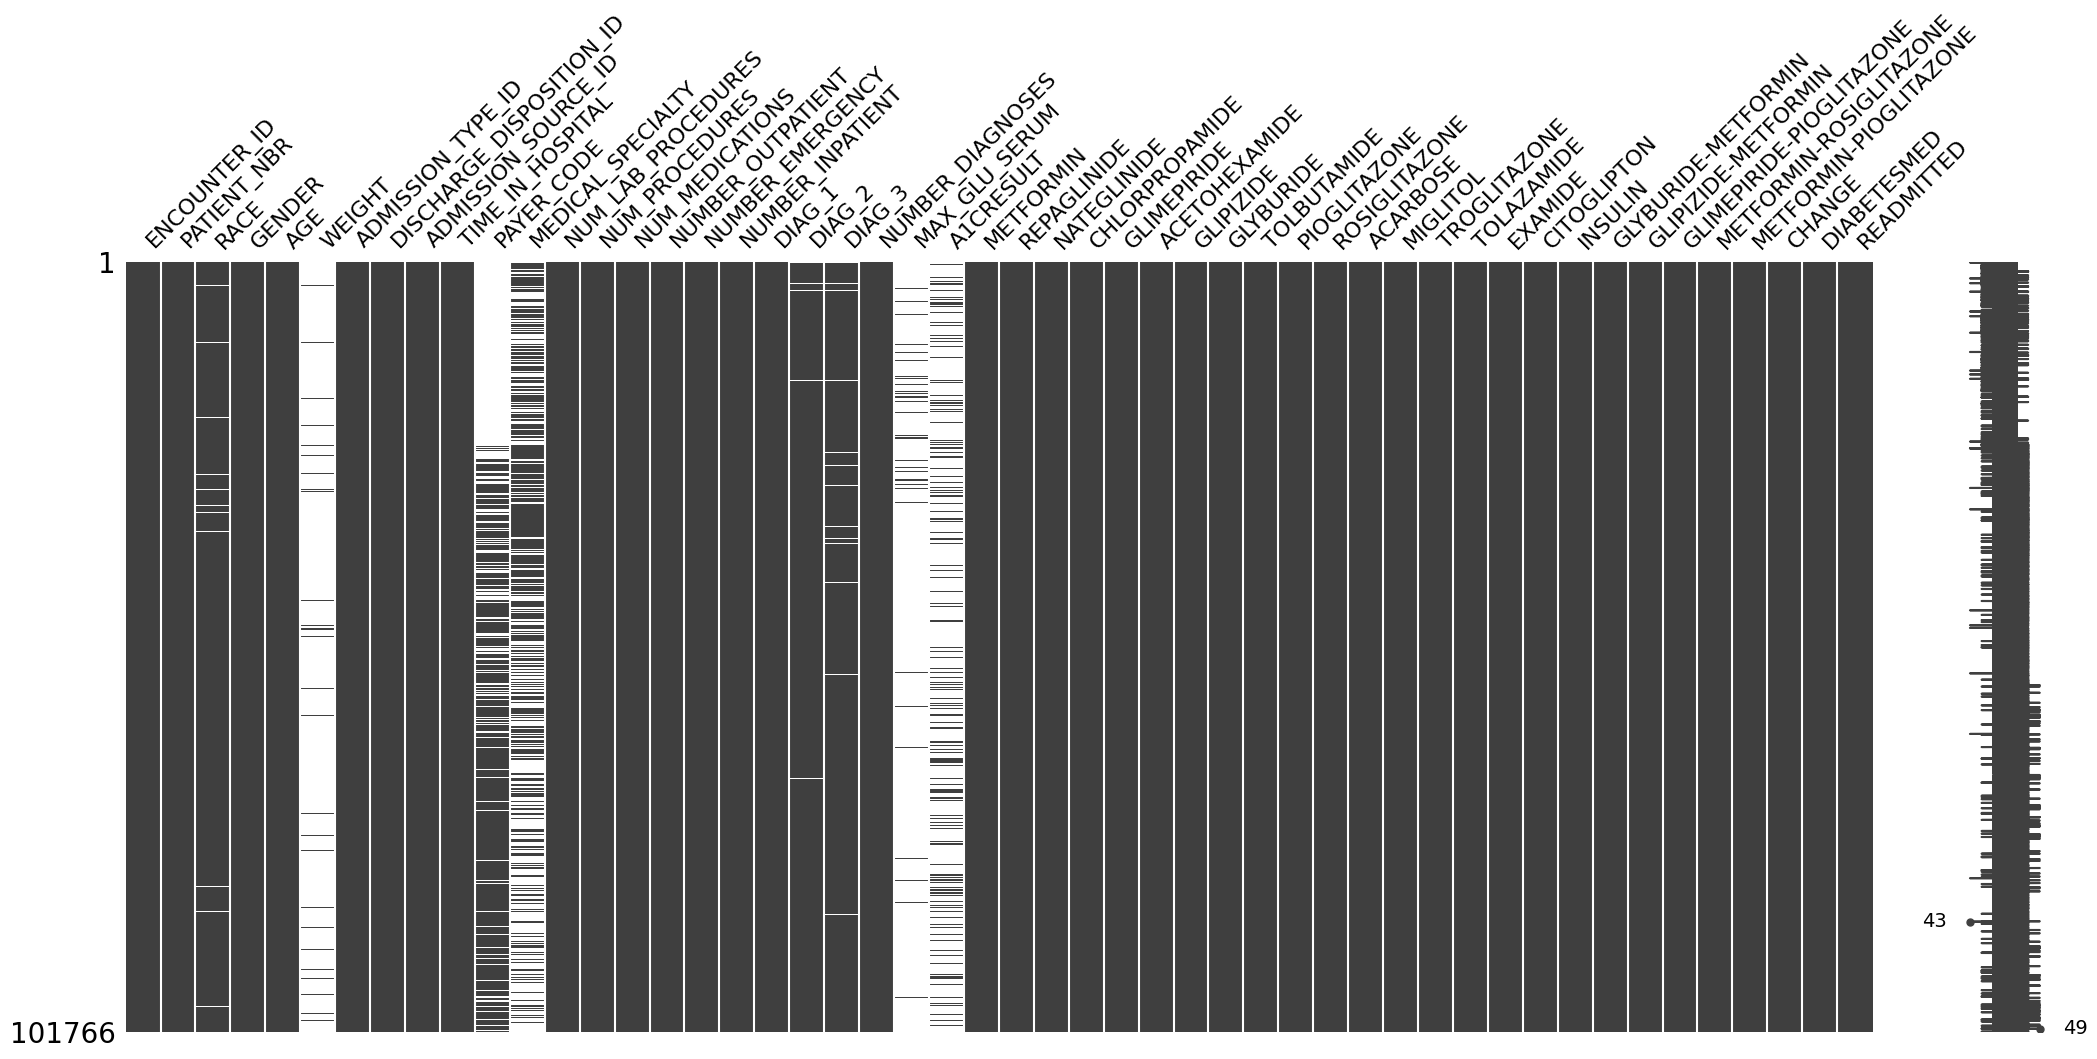

In [5]:
msno.matrix(fileReaded)

#### Value Counts of Categoricals vs. Y

In [6]:
catCols = [
    'RACE', 'GENDER', 'AGE', 'WEIGHT', 'DIAG_1', 'DIAG_2', 'DIAG_3',
    'ADMISSION_TYPE_ID', 'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID',
    'MEDICAL_SPECIALTY', 'MAX_GLU_SERUM', 'A1CRESULT',
    'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE',
    'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
    'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
    'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN',
    'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN',
    'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE',
    'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED'
]

In [7]:
for col in catCols:
    
    if col in ['MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3',]:
        continue
    
    display(
        pd.concat(
            [
                fileReaded[[col, 'READMITTED']].value_counts(dropna = False, normalize = False),
                fileReaded[[col, 'READMITTED']].value_counts(dropna = False, normalize = True),
            ],
            axis=1
        ).rename(
            columns = {0:'count', 1:'proportion'}
        ).assign(
            proportion = lambda x: x['proportion'] * 100
        ).reset_index(
            drop = False
        ).merge(
            fileReaded[col].value_counts(
                dropna = False
            ).to_frame().reset_index(
                drop = False
            ).rename(
                columns = {col: 'group_proportion', 'index':col}
            )
        ).assign(
            group_proportion = lambda x: (x['count']/x['group_proportion'])*100
        ).set_index(
            [col, 'READMITTED']
        ).sort_index().style.format(
            {'proportion': "{:,.2f}%",'group_proportion': "{:,.2f}%",'count': "{:,.0f}"}
        )
    )

#### Drop Columns with no Data (not enough information  OR irrelevant)

In [8]:
dropCols = [
    'PAYER_CODE', 

    'WEIGHT',
    'ACETOHEXAMIDE', 'TROGLITAZONE', 'TOLAZAMIDE',  
    'EXAMIDE', 'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN',
    'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 
    'METFORMIN-PIOGLITAZONE', 'CITOGLIPTON', 'TOLBUTAMIDE',
    'ACARBOSE'
]

catCols = list(set(catCols) - set(dropCols))

In [9]:
fileReaded = fileReaded.drop(
    columns = dropCols
)

In [10]:
########################################################################
########################################################################

### Reduce to only to categories in target.
### Reducing inbalanced
### Binary classification has the same purpose

fileReaded['READMITTED'] = fileReaded['READMITTED'].replace('<30', '>30')


########################################################################
########################################################################

## Fit model

### Data Trasform

#### Fill NaN

In [11]:
fileReaded = fileReaded.dropna(subset=['GENDER', 'AGE'], how='any').reset_index(drop = True)

fileReaded['MEDICAL_SPECIALTY'] = fileReaded['MEDICAL_SPECIALTY'].fillna('No')
fileReaded['MAX_GLU_SERUM'] = fileReaded['MAX_GLU_SERUM'].fillna('No')
fileReaded['A1CRESULT'] = fileReaded['A1CRESULT'].fillna('No')

fileReaded['RACE'] = fileReaded['RACE'].fillna('Other')

#### Uniffiying Diags

In [12]:
numDiagToKeep = 25

In [13]:
diagsDF = fileReaded[['DIAG_1', 'DIAG_2', 'DIAG_3']].reset_index(drop = False).copy()
diagsDF = pd.melt(
    diagsDF, 
    id_vars=['index'], 
    value_vars=['DIAG_1', 'DIAG_2', 'DIAG_3'],
    var_name='VAR', value_name='DIAG'
).drop(columns = ['VAR'])

diagToKeep = diagsDF['DIAG'].value_counts(
    normalize = False
).to_frame().reset_index(drop = False).rename(
    columns = {'DIAG': 'count', 'index': 'DIAG'}
).loc[0:numDiagToKeep - 1]['DIAG'].to_list()

diagsDF = diagsDF[diagsDF['DIAG'].isin(diagToKeep)].reset_index(drop = True)
diagsDF['IN'] = 1

diagsDF = diagsDF.pivot_table(index = 'index', columns=['DIAG'], values=['IN'], aggfunc='sum').fillna(0).astype(int)
diagsDF.columns = [i[1] for i in diagsDF.columns]

In [14]:
fileReaded = fileReaded.merge(diagsDF, left_index = True, right_index = True, how = 'left')
fileReaded = fileReaded.drop(columns = ['DIAG_1', 'DIAG_2', 'DIAG_3'])

for col in diagToKeep:
    fileReaded[col] = fileReaded[col].fillna(0).astype(int)

del diagsDF

In [15]:
catCols = list(set(catCols) - set(['DIAG_1', 'DIAG_2', 'DIAG_3']))

#### One hot Encode

##### Cols with Procedure Results

In [16]:
oneHotCols1 = list(
    set(catCols) - set(
        [
            'GENDER', 'RACE', 'AGE',
            'ADMISSION_TYPE_ID',
            'DISCHARGE_DISPOSITION_ID',
            'ADMISSION_SOURCE_ID'
        ]
    )
)

In [17]:
enc1 = OneHotEncoder(handle_unknown='error', drop = ['No'] * len(oneHotCols1), max_categories = 10)
enc1.fit(fileReaded[oneHotCols1])
#enc1.transform(fileReaded[oneHotCols1]).toarray()
#enc1.get_feature_names_out()

OneHotEncoder(drop=['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No',
                    'No', 'No', 'No', 'No', 'No', 'No'],
              max_categories=10)

##### Cols with personal info

In [18]:
oneHotCols2 = [
    'GENDER', 'RACE', 'AGE',
    'ADMISSION_TYPE_ID',
    'DISCHARGE_DISPOSITION_ID',
    'ADMISSION_SOURCE_ID',
    'NUMBER_DIAGNOSES',
    'NUMBER_OUTPATIENT',
    'NUMBER_EMERGENCY',
    'NUMBER_INPATIENT'
]


enc2 = OneHotEncoder(handle_unknown='error', drop = 'first', max_categories = 10)
enc2.fit(fileReaded[oneHotCols2])
#enc2.transform(fileReaded[oneHotCols2]).toarray()
#enc2.get_feature_names_out()

OneHotEncoder(drop='first', max_categories=10)

#### Label Encoding

##### Y

In [19]:
fileReaded['READMITTED'].value_counts() ## Unbalanced

NO     54861
>30    46902
Name: READMITTED, dtype: int64

In [20]:
le = LabelEncoder()
le.fit(fileReaded['READMITTED'])
#le.classes_

LabelEncoder()

### X - y Concat

In [21]:
X = pd.concat(
    [
        pd.DataFrame(enc1.transform(fileReaded[oneHotCols1]).toarray(), columns = enc1.get_feature_names_out()).astype(int),
        pd.DataFrame(enc2.transform(fileReaded[oneHotCols2]).toarray(), columns = enc2.get_feature_names_out()).astype(int),
        fileReaded[
            [
                'TIME_IN_HOSPITAL',
                'NUM_LAB_PROCEDURES',
                'NUM_PROCEDURES',
                'NUM_MEDICATIONS',
            ] + diagToKeep
        ]
    ],
    axis = 1,
)

y = pd.DataFrame(le.transform(fileReaded['READMITTED']), columns = ['y'])

### PCA

In [22]:
PCA_N_COMPONENTS = 15
compColumnsNames = [
    'COMP_{}'.format(str(i).zfill(len(str(PCA_N_COMPONENTS)))) 
    for i in range(PCA_N_COMPONENTS)
]

pca = PCA(n_components=PCA_N_COMPONENTS)
X = pd.DataFrame(
    pca.fit_transform(X), 
    columns = compColumnsNames
)

print("% Explaned Variance\n")

pprint(
    dict(
        zip(
            compColumnsNames,
            ["{:,.2f}%".format(i*100) for i in pca.explained_variance_ratio_]
        )
    )
)
    

% Explaned Variance

{'COMP_00': '83.38%',
 'COMP_01': '13.20%',
 'COMP_02': '1.37%',
 'COMP_03': '0.53%',
 'COMP_04': '0.08%',
 'COMP_05': '0.08%',
 'COMP_06': '0.06%',
 'COMP_07': '0.05%',
 'COMP_08': '0.05%',
 'COMP_09': '0.05%',
 'COMP_10': '0.04%',
 'COMP_11': '0.04%',
 'COMP_12': '0.04%',
 'COMP_13': '0.04%',
 'COMP_14': '0.03%'}


### Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Baseline: AutoML using PyCaret

In [27]:
from pycaret.classification import *

In [28]:
s = setup(pd.concat([X_train, y_train], axis = 1), target = 'y', fix_imbalance = True)

,Description,Value
0,Session id,2245
1,Target,y
2,Target type,Binary
3,Original data shape,"(91586, 16)"
4,Transformed data shape,"(91586, 16)"
5,Transformed train set shape,"(64110, 16)"
6,Transformed test set shape,"(27476, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [29]:
best = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,08:46:37
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


KeyboardInterrupt: 

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Best AutoML model

In [31]:
lightgbm = LGBMClassifier(n_estimators = 300, num_leaves = 50, learning_rate = 0.01, max_depth = 50)
lightgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 49355, number of negative: 42231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 91586, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538892 -> initscore=0.155885
[LightGBM] [Info] Start training from score 0.155885


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.01, max_depth=50,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=None, num_leaves=50, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [32]:
print('Train\n')

y_train_pred = lightgbm.predict(X_train)
print('Confusion Matrix')
print(confusion_matrix(y_train, y_train_pred))

accuracy = lightgbm.score(X_train, y_train)
print("\nAccuracy: {:,.2f}%".format(accuracy))

print('\n*********************************************\n')

print('Test\n')

y_test_pred = lightgbm.predict(X_test)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred))

accuracy = lightgbm.score(X_test, y_test)
print("\nAccuracy: {:,.2f}%".format(accuracy))

Train

Confusion Matrix
[[20064 22167]
 [13005 36350]]

Accuracy: 0.62%

*********************************************

Test

Confusion Matrix
[[2109 2562]
 [1671 3835]]

Accuracy: 0.58%


### Random Forest Classifier

In [24]:
clf = RandomForestClassifier(
    n_estimators = 25, 
    max_depth=50, 
    criterion = 'entropy', 
    random_state=42,
    class_weight='balanced'
)

clf.fit(X_train, y_train)

C:\Users\dan1e\AppData\Local\Temp\ipykernel_5392\1039645584.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=50, n_estimators=25, random_state=42)

In [25]:
print('Train\n')

y_train_pred = clf.predict(X_train)
print('Confusion Matrix')
print(confusion_matrix(y_train, y_train_pred))

print('\n*********************************************\n')

print('Test\n')

y_test_pred = clf.predict(X_test)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred))

Train

Confusion Matrix
[[42204    27]
 [   12 49343]]

*********************************************

Test

Confusion Matrix
[[2194 2477]
 [1924 3582]]


In [26]:
print("Feature Importance\n")

{
    k: "{:,.2f}".format(v) 
    for k, v in sorted(
        dict(zip(X_train.columns, clf.feature_importances_)).items(), 
        key=lambda item: item[1], 
        reverse = True
    )
}

Feature Importance



{'COMP_05': '0.07',
 'COMP_03': '0.07',
 'COMP_00': '0.07',
 'COMP_01': '0.07',
 'COMP_02': '0.07',
 'COMP_04': '0.07',
 'COMP_14': '0.07',
 'COMP_13': '0.07',
 'COMP_12': '0.07',
 'COMP_06': '0.06',
 'COMP_07': '0.06',
 'COMP_10': '0.06',
 'COMP_08': '0.06',
 'COMP_09': '0.06',
 'COMP_11': '0.06'}

### Neural Network

In [30]:
classWeight = y.value_counts(normalize = True).to_frame().reset_index(drop = False).set_index('y')[0].to_dict()

In [40]:
nn = Sequential()

nn.add(Dense(16, input_dim = X.shape[1]))
nn.add(Activation("relu"))

nn.add(Dense(32))
nn.add(Activation("relu"))

nn.add(Dense(64))
nn.add(Activation("relu"))

nn.add(Dense(32))
nn.add(Activation("relu"))

nn.add(Dense(16))
nn.add(Activation("relu"))

nn.add(Dense(8))
nn.add(Activation("relu"))

nn.add(Dense(1 if len(classWeight) == 2 else len(classWeight)))
nn.add(Activation("sigmoid"))

nn.compile(
    loss='binary_crossentropy' if len(classWeight) == 2 else 'categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)
                                  
nn.fit(
    X_train.to_numpy(), 
    y_train['y'], 
    epochs=1000, 
    batch_size=150,
    class_weight = classWeight
)

scores = nn.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (nn.metrics_names[1], scores[1]*100))

Epoch 1/1000
611/611 [==============================] - 2s 2ms/step - loss: 0.3388 - accuracy: 0.5486
Epoch 2/1000
611/611 [==============================] - 1s 2ms/step - loss: 0.3355 - accuracy: 0.5642
Epoch 3/1000
611/611 [==============================] - 1s 2ms/step - loss: 0.3345 - accuracy: 0.5689
Epoch 4/1000
611/611 [==============================] - 1s 2ms/step - loss: 0.3340 - accuracy: 0.5723
Epoch 5/1000
611/611 [==============================] - 2s 3ms/step - loss: 0.3339 - accuracy: 0.5729
Epoch 6/1000
611/611 [==============================] - 2s 3ms/step - loss: 0.3335 - accuracy: 0.5743
Epoch 7/1000
611/611 [==============================] - 3s 5ms/step - loss: 0.3331 - accuracy: 0.5759
Epoch 8/1000
611/611 [==============================] - 3s 5ms/step - loss: 0.3330 - accuracy: 0.5754
Epoch 9/1000
611/611 [==============================] - 2s 4ms/step - loss: 0.3326 - accuracy: 0.5770
Epoch 10/1000
611/611 [==============================] - 2s 4ms/step - loss: 0.332

In [42]:
print('Train\n')

y_train_pred = nn.predict(X_train)
y_train_pred = [[round(i[0])] for i in y_train_pred]

print('Confusion Matrix')
print(confusion_matrix(y_train, y_train_pred))


print('\n*********************************************\n')

print('Test\n')

y_test_pred = nn.predict(X_test)
y_test_pred = [[round(i[0])] for i in y_test_pred]
print('Confusion Matrix')
print(confusion_matrix(y_test, y_test_pred))

Train

2863/2863 [==============================] - 3s 1ms/step
Confusion Matrix
[[18441 23790]
 [ 6892 42463]]

*********************************************

Test

319/319 [==============================] - 1s 2ms/step
Confusion Matrix
[[1515 3156]
 [1316 4190]]


Result: None of the models proposed above has been able to correctly fit the data to predict the response variable. Perhaps, due to the amount of data, which is very little. It is recommended:
* Search for more data (if possible).
* Improve the data processing (if possible).
* Perform some Feature Engineering technique to increase the information provided by some of the variables.